<a href="https://colab.research.google.com/github/vjacobsen/Inventory_Simulation/blob/main/Inventory_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Simulation

In [2]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import norm
from scipy import stats

## Optional: Enable data table display
%load_ext google.colab.data_table

$ EOQ = \sqrt{2 *\dfrac{Annual \ Demand * Cost \ per \ Order}{Annual \ Holding \ Cost \ per \ Unit}} $


* Annual holding cost is set at 15% of the bottle's cost
* The bottle cost is 60% of the retail value  



## Functions

The reorder point is calculated as the sum of the average demand during lead time, plus the safety stock, plus the undershoot buffer. The undershoot happens when the order is generated below the reorder point, a very common and natural occurence when demand is not fixed to 1 or 0. To account for this, an additional parameter is added to the lead time demand and deviation.

In [143]:
def run_simulation(demand_input):  

  global stock,inventory_data,safety_stock,lt_demand_variability,mean_lt_demand,\
          demand,reorder_point,open_orders,lost_sales,on_order_qty,period,closed_orders,\
          delivery_this_period
  
  # Inventory replenishment parameters, undershoot correction
  lt_demand_variability,mean_lt_demand = lt_stdev_func(1000)  
  
  # Undershoot as a function of mean period's demand
  mean_undershoot = np.mean(demand_input)/2
  mean_lt_demand = mean_lt_demand+ np.mean(demand_input)/2

  stdev_undershoot = np.std(demand_input/2)
  lt_demand_variability = lt_demand_variability + stdev_undershoot
  
  safety_stock = round(stats.norm.ppf(desired_service_level) * lt_demand_variability,0)

  reorder_point = round(mean_lt_demand + safety_stock,0) 
  
  lost_sales = 0
  open_orders = {}
  closed_orders = {}
  next_order_id = 0
  on_order_qty = 0
  inventory_data = []

  # Start inventory as function of demand
  initial_inventory = reorder_point + actual_order_qty/2
  stock = initial_inventory
  stockouts = 0

  # Simulate 
  for period in np.arange(1,periods+1):
    
    stock_start = stock
    demand = round(demand_input[period-1]) 

    ## Subtract sold units from inventory - demand before order arrives 
    if stock == 0: # Currently out of stock awaiting replenishment
      lost_sales = demand
      stock = 0
      stockouts = 0
      inventory_out_of_stock = 1
    
    elif demand > stock: # Stockout event
      lost_sales = abs(demand - stock)
      stock = 0
      stockouts = 1 # Period where stockout occured
      percent_filled = stock/demand 
      inventory_out_of_stock = 1
    
    else: # No stockout, inventory still positve
      stock = stock - demand
      lost_sales = 0
      stockouts = 0
      inventory_out_of_stock = 0

    ## Create replnishment order?
    if stock + on_order_qty <= reorder_point: 
      order_count = 1
      oq = actual_order_qty
      order_lead_time = round(lead_time)
      delivery_period = period + order_lead_time
      
      order_details = {'delivery_period':delivery_period,
                        'order_qty':oq, 
                        'ordered_period':period
                       }
                       
      on_order_qty = on_order_qty + oq # Update on-order qty
      open_orders[period] = order_details # Add order to dictionary

    else:
      order_count = 0

    ## Replenish stock - deliver order 
    delete_orders = [] # Will be used later to pop orders from open order dict
    for order_id in open_orders: 
      if open_orders[order_id]['delivery_period'] == period:
        delivery_qty = open_orders[order_id]['order_qty']
        stock = stock + delivery_qty # Add order qty to stock
        closed_orders[order_id] = open_orders[order_id] # Move to closed orders
        on_order_qty = on_order_qty - delivery_qty
        delete_orders.append(order_id)
 
    for order_id in delete_orders: 
      open_orders.pop(order_id) # Remove delivered orders from open orders dict
      
    ## Metrics list
    inventory_data.append([period, 
                           demand, 
                           stock, 
                           on_order_qty, 
                           lost_sales,
                           order_count,
                           stockouts,
                           inventory_out_of_stock,
                           stock_start          
                           ]
                          ) 
  

  # Metrics data frame  
  inventory_data = pd.DataFrame(inventory_data,
                                columns=['period',
                                         'demand',
                                         'stock_on_hand',
                                         'stock_on_order',
                                         'lost_sales',
                                         'order_count',
                                         'stockouts',
                                         'inventory_out_of_stock',
                                         'stock_start'
                                         ]
                                ) 
  
# Calculate lead time demand variability - bootstrap the demand periods
# Calculate standard deviation ofsum of demand sampled in groups of n periods, where n is the lead time duration 
def lt_stdev_func(samples):

  global stdev_list,lt_demand_list
  
  i=0
  lt_demand_list = []
  demand_list = list(demand_array)
  
  while i < samples: # Calculate multiple samples of potential lead time demand
    i = i+1
    sample_data = random.sample(demand_list,lead_time)
    lt_demand = sum(sample_data)
    lt_demand_list.append(lt_demand)
    
  return np.std(lt_demand_list, ddof=1),np.mean(lt_demand_list)


# Metrics calculation after simulation run is finished
def compute_metrics():

    global zero_on_hand_periods_pcnt, fulfilled_demand, total_demand, average_demand,\
            total_orders, cycles_without_stockout
    
    # Percentage of inventory cycles without a stockout event
    inventory_cycles = len(closed_orders) 
    cycles_without_stockout = 1 - round(inventory_data['stockouts'].sum() / inventory_cycles,3)
     
    total_demand = round(inventory_data['demand'].sum())
    
    average_demand = round(inventory_data['demand'].mean())

calculate zero on hand periods based on number of periods in lead time!!!!

**Service level is the probability that the amount of inventory on hand during the lead time is sufficient to meet expected demand – that is, the probability that a stockout will not occur.**

## Input parameters

In [45]:
# Input parameters
item_cost = 5
order_cost = 2
holding_cost = .05 # Percent of item cost

periods = 204 # number of periods to simulate
period_freq = 52 # number of periods in 1 year
lead_time = 2 # periods
desired_service_level = 0.9

# Generate random demand or provide list. UOM: Per period
mean_demand = 1000 
stdev_demand = 300 

# Calculated stock replenishment tresholds
annual_demand = mean_demand * period_freq
actual_order_qty = 6000

## Run simulation once
After running, we'll analyze the simulation's individual results

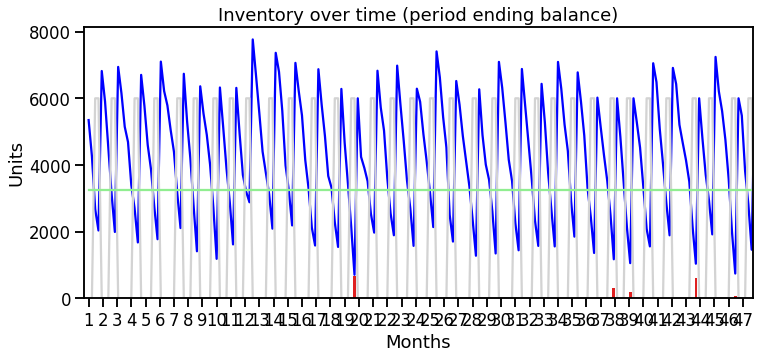


 Actual order qty 6000 
 safety stock 748.0 
 lead time demand  2495.5696819044783 
 reorder point  3244.0 
 desired service level 0.9 



Stockout envents -  5
Cycles without stockout -  85.0 %
_______________________________________________________________________ 

       period  demand  ...  inventory_out_of_stock  stock_start
count     204     204  ...                     204          204
mean      102    1007  ...                       0         4197
std        59     313  ...                       0         1799
min         1     252  ...                       0          706
25%        51     776  ...                       0         2693
50%       102    1044  ...                       0         4152
75%       153    1203  ...                       0         5791
max       204    2022  ...                       1         7766

[8 rows x 9 columns]


In [46]:
demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))

run_simulation(demand_array)
compute_metrics()

# Plot
df = inventory_data
sns.set_context('talk')
plt.figure(figsize=(12,5))
plt.title('Inventory over time (period ending balance)')
sns.lineplot(x=df['period'],y=df['stock_on_hand'],color='blue')
sns.lineplot(x=df['period'],y=df['stock_on_order'], color='lightgrey')
sns.lineplot(x=df['period'],y=reorder_point, color='lightgreen')
sns.barplot(x=df['period'],y=df['lost_sales'], color='red')
plt.ylabel('Units')
plt.xlabel('Months')
plt.xticks(np.arange(1, max(df['period']), period_freq/12))
plt.show()

# Print report
print('\n', 
      'Actual order qty', actual_order_qty, '\n',
      'safety stock', safety_stock, '\n',
      'lead time demand ', mean_lt_demand,'\n',
      'reorder point ', reorder_point ,'\n',
      'desired service level', desired_service_level, '\n'
      )
print('\n')

print( "Stockout envents - ", inventory_data['stockouts'].sum())
print("Cycles without stockout - ", 100*round(cycles_without_stockout,2),"%")

print("_______________________________________________________________________ \n")

print(inventory_data.describe().astype(int))

# Batch simulation

In [144]:
def batch_simulation(service_level=0.95,runs=400):
  
  global desired_service_level
  
  # Initialize variables
  desired_service_level = service_level
  simulation_number = 0
  metrics = []
  simulation_runs = runs

  while simulation_number < simulation_runs:  
    demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))
    run_simulation(demand_array)
    compute_metrics()
    
    metrics.append([
                    total_demand,
                    average_demand,
                    cycles_without_stockout
                    ]
                  )
    
    simulation_number = simulation_number + 1

  results = pd.DataFrame(metrics,columns=[
                                'mean_total_demand',
                                'mean_average_demand',
                                'cycles_without_stockout'])
  return results

In [145]:
results = batch_simulation(.95)
print("Mean Service Level of Simulation Runs")
print(round(results['cycles_without_stockout'].mean(),3))

Mean Service Level of Simulation Runs
0.949


## Visualize Simulation Results



### Lead Time Demand
We can see lead time demand is normally distributeed

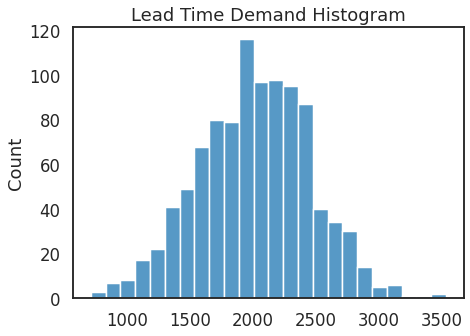

In [146]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(7,5))
plt.title('Lead Time Demand Histogram')
sns.histplot(lt_demand_list)
plt.show()

### Actual Service Level Counts

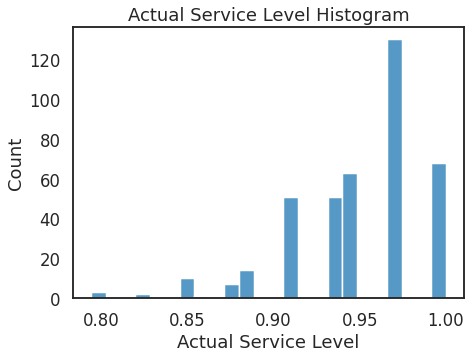

In [152]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(7,5))
plt.title('Actual Service Level Histogram')
sns.histplot(x=results['cycles_without_stockout'])
plt.xlabel('Actual Service Level')
plt.show()

### Compare Theoretical vs Actual service levels

Ideally, the correlation coefficient between service levels should be equal to 1. This would mean that the theoretical calculation actually follow the calculated service levels from the simulation. For example, if we calculate replenishment parameters with a desired service of 95%, the simulation results should be as close to 95% as possible.

For this, we'll run the simulation for various theoretical service levels and compare to the observed service level

In [117]:
# Create list of service levels to be tested and run 400 simulations (default function value) for each

theoretical_service_levels = np.arange(0.90,0.995,0.005).round(3)
observed_service_levels = [] 

for sl in theoretical_service_levels:
  results = batch_simulation(sl).mean().round(3)
  observed_service_levels.append(results['cycles_without_stockout'])

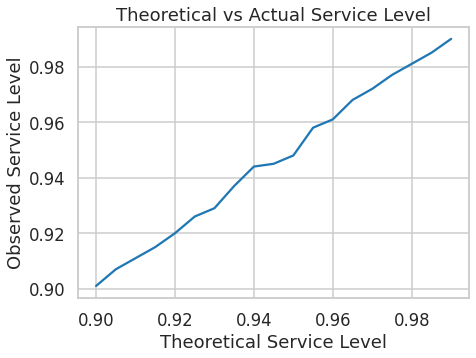


 Correlation coefficient: 0.999 


In [118]:
# Plot
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))
plt.title('Theoretical vs Actual Service Level')
sns.lineplot(x=theoretical_service_levels,y=observed_service_levels)
plt.ylabel("Observed Service Level")
plt.xlabel("Theoretical Service Level")
plt.show()

# Calculate correlation coefficient
corr_coef = np.corrcoef(x=theoretical_service_level,y=observed_service_levels)[0][1].round(3)
print("\n Correlation coefficient: {} ".format(corr_coef))